<a href="https://colab.research.google.com/github/YehezkelShay/hello-world/blob/master/Copy_of_GAN_Training_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generative Adversarial Networks in Pytorch**

## Installing Pytorch and prerequisites 

In [0]:
!pip install -q torch==1.0.0 torchvision
!pip install -q tqdm


     |████████████████████████████████| 591.8MB 18kB/s 


In [0]:
%reset -f 
%matplotlib inline


import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()
# use_cuda = False

print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

__Python VERSION: 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
__pyTorch VERSION: 1.0.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
__CUDNN VERSION: 7401
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
USE CUDA=True


## Initial Imports and setting CUDA


In [0]:
import os
import shutil
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm_notebook
from torchvision import utils
from torch.autograd import Variable
from torch import autograd
import torch.optim as optim
import time as t

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Hyperparametes and Directory creation

In [0]:
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 20
batch_size = 100
sample_dir = 'samples'

In [0]:
# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
else:
    shutil.rmtree(sample_dir)
    os.makedirs(sample_dir)

## Creating a DataLoader for MNIST

here you can see how we normalize the mnist data to [-1,1] using minmax normalization, then feeding that transform into the dataset and creating a loader

In [0]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: (x - 0.5) * 2) # normalize the data to [-1,1]
                                ])


In [0]:
mnist = torchvision.datasets.MNIST(root='../../data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 8758160.34it/s]                            


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135444.13it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2199810.13it/s]                            
0it [00:00, ?it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 49983.84it/s]            


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


## Discriminator
A simple Discriminator that is 2 dense layers with leaky relu activations and a dense layer output with sigmoid activation

In [0]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
D = D.to(device)

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))

## Generator
A simple Generator that is 2 dense layers with relu activations and a final dense layer with TanH activation (which is constrained to [-1,1])

In [0]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
G = G.to(device)

criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))

## Training Loop
Here we define the training loop of the GAN, a training loop needs to train both the generator and the discriminator at the same time for each batch.
![alt text](https://cdn-images-1.medium.com/max/1600/1*hlFyF-klXQunFpmoeA89jQ.png)

Epoch [0/20], d_loss: 0.5409, g_loss: 1.6443, D(x): 0.74, D(G(z)): 0.18


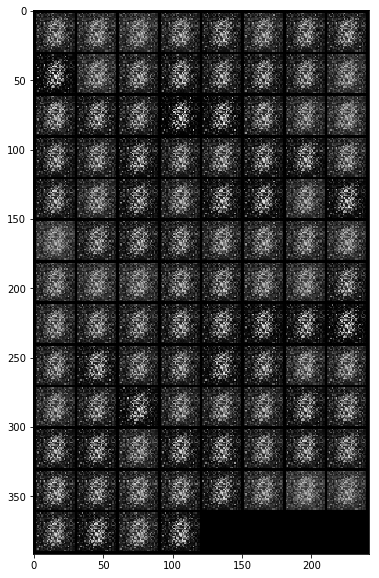

Epoch [1/20], d_loss: 0.4467, g_loss: 4.2246, D(x): 0.94, D(G(z)): 0.30


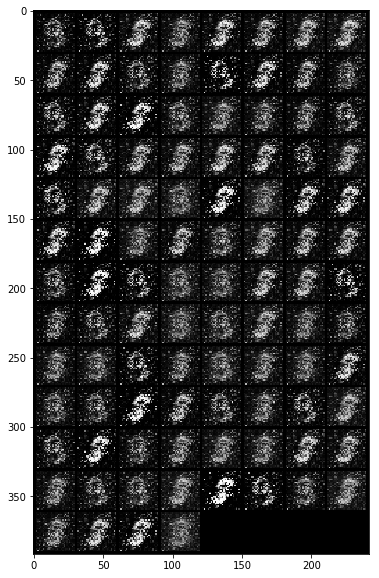

Epoch [2/20], d_loss: 0.2763, g_loss: 3.3653, D(x): 0.83, D(G(z)): 0.03


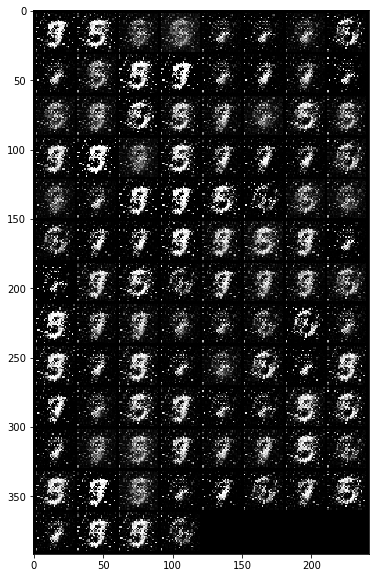

Epoch [3/20], d_loss: 0.2036, g_loss: 3.7136, D(x): 0.92, D(G(z)): 0.09


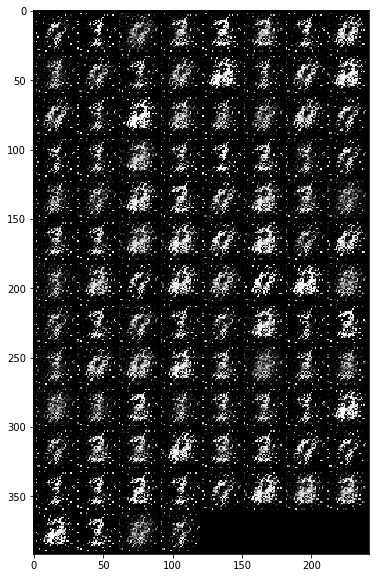

Epoch [4/20], d_loss: 0.2660, g_loss: 3.6115, D(x): 0.91, D(G(z)): 0.14


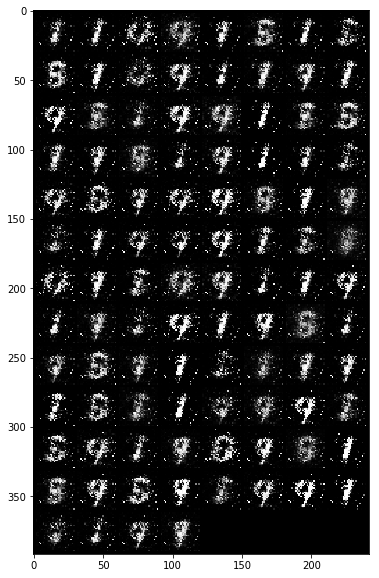

Epoch [5/20], d_loss: 0.3355, g_loss: 2.9153, D(x): 0.90, D(G(z)): 0.13


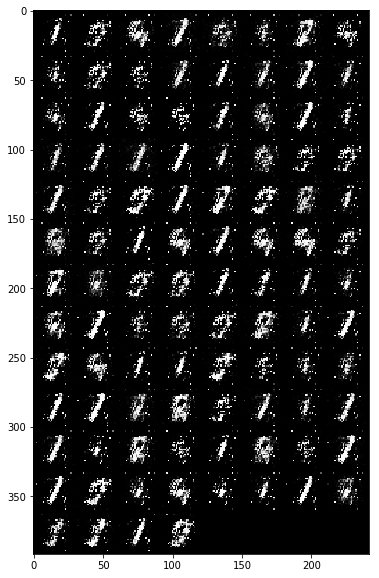

Epoch [6/20], d_loss: 0.0978, g_loss: 5.3684, D(x): 0.97, D(G(z)): 0.02


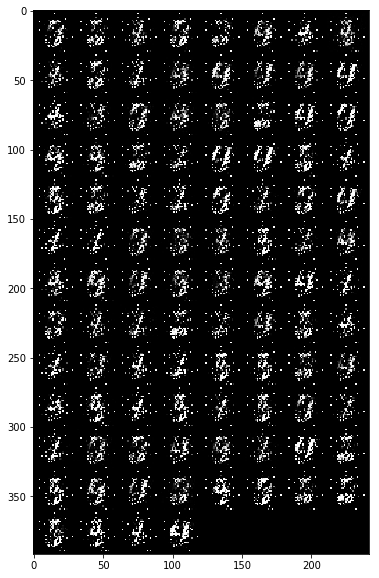

Epoch [7/20], d_loss: 0.1824, g_loss: 4.0857, D(x): 0.95, D(G(z)): 0.11


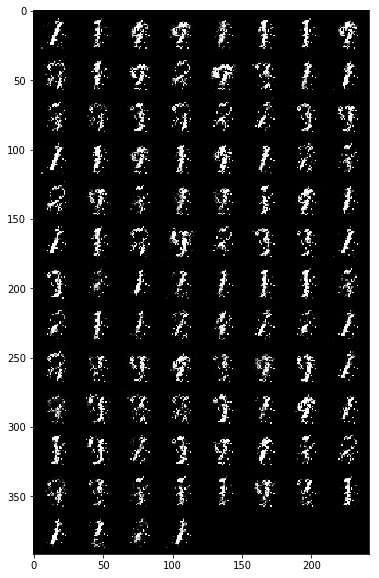

Epoch [8/20], d_loss: 1.0937, g_loss: 2.3906, D(x): 0.68, D(G(z)): 0.00


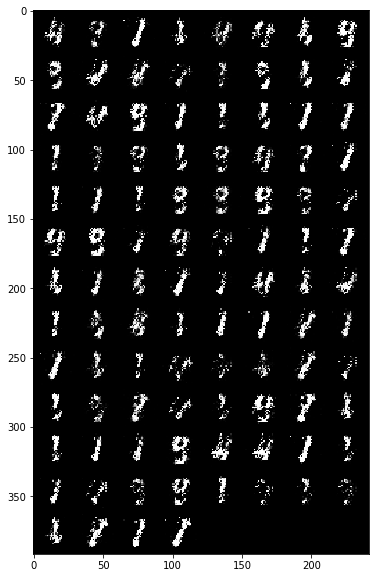

Epoch [9/20], d_loss: 0.1638, g_loss: 2.5729, D(x): 0.94, D(G(z)): 0.03


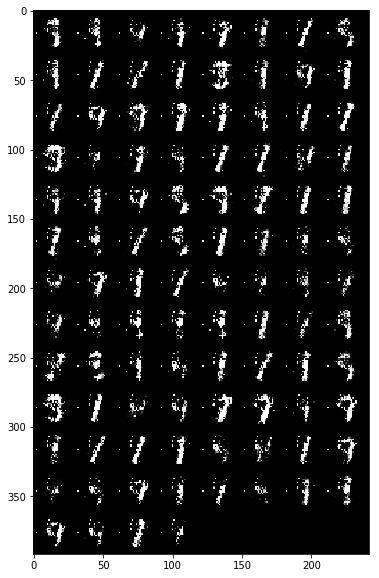

Epoch [10/20], d_loss: 0.3356, g_loss: 2.6410, D(x): 0.89, D(G(z)): 0.07


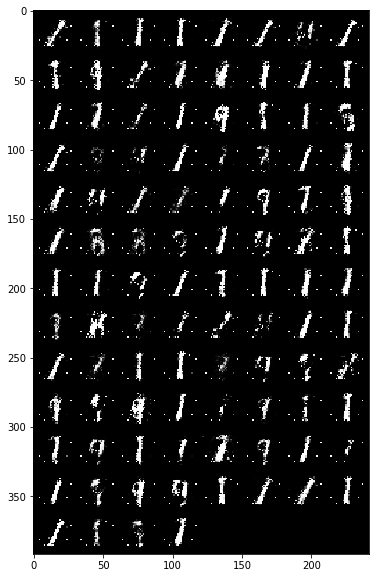

Epoch [11/20], d_loss: 0.2258, g_loss: 3.3275, D(x): 0.90, D(G(z)): 0.04


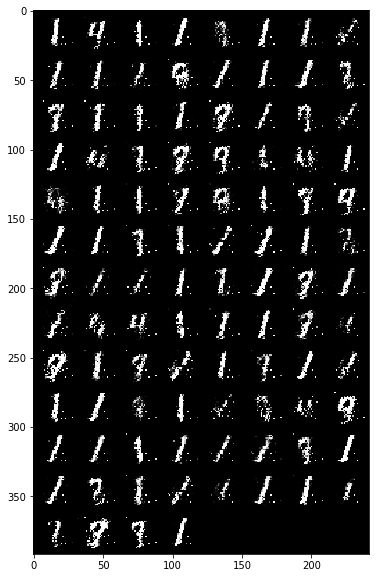

Epoch [12/20], d_loss: 0.3962, g_loss: 3.0378, D(x): 0.92, D(G(z)): 0.22


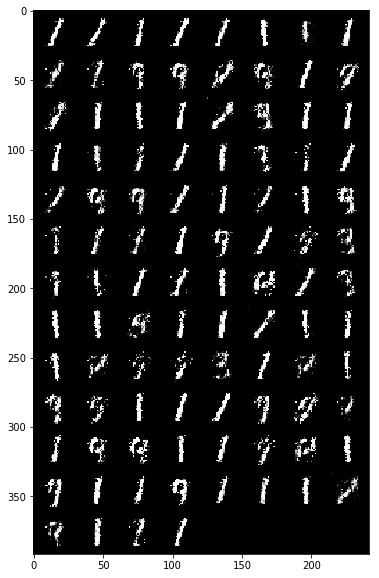

Epoch [13/20], d_loss: 0.3057, g_loss: 2.5264, D(x): 0.91, D(G(z)): 0.13


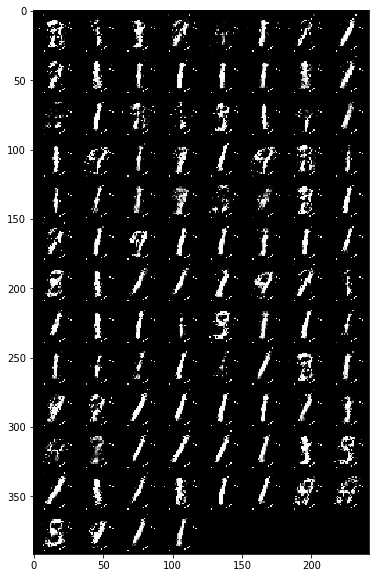

Epoch [14/20], d_loss: 0.7471, g_loss: 1.2878, D(x): 0.71, D(G(z)): 0.16


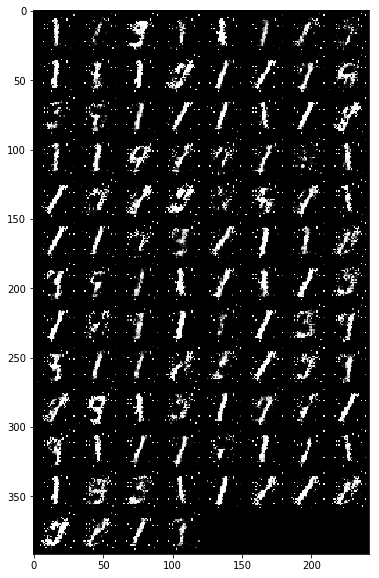

Epoch [15/20], d_loss: 0.3226, g_loss: 2.2621, D(x): 0.86, D(G(z)): 0.10


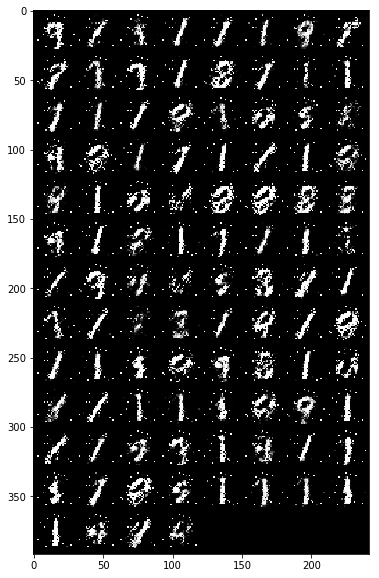

Epoch [16/20], d_loss: 0.1760, g_loss: 3.2456, D(x): 0.93, D(G(z)): 0.08


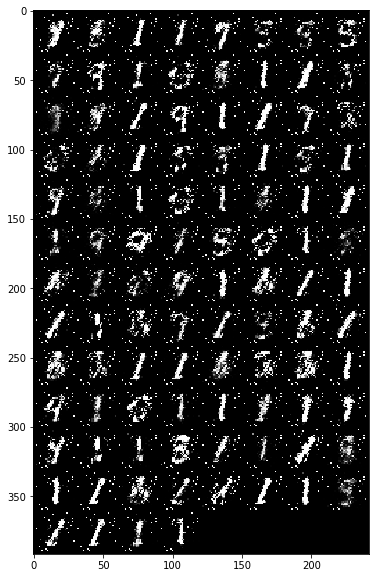

Epoch [17/20], d_loss: 0.6689, g_loss: 3.3649, D(x): 0.68, D(G(z)): 0.03


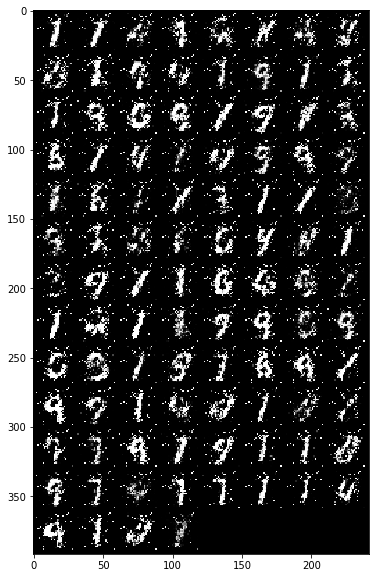

Epoch [18/20], d_loss: 0.5766, g_loss: 2.4451, D(x): 0.72, D(G(z)): 0.07


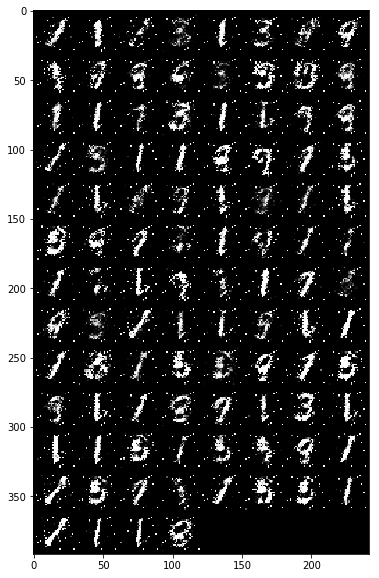

Epoch [19/20], d_loss: 0.4600, g_loss: 2.3071, D(x): 0.84, D(G(z)): 0.20


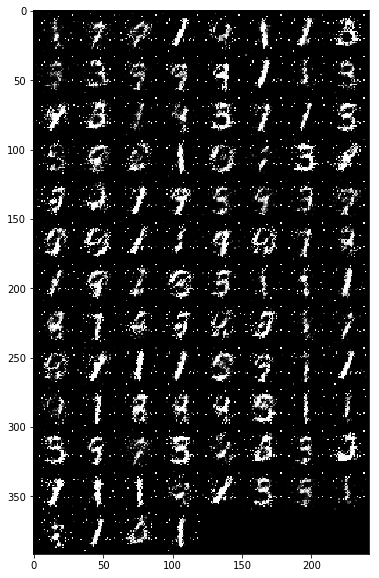

In [0]:
#helper functions
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

total_step = len(data_loader)
for epoch in tqdm_notebook(range(num_epochs)):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        if images.shape[1] != image_size:
          continue
        
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) == total_step:
            print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(-1, 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    # Save sampled images
    fake_images = fake_images.reshape(-1, 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    fig, ax = plt.subplots(figsize=(20, 10))
    img=mpimg.imread(os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    ax.imshow(img)
    plt.show()
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

# Training WGAN-GP in Keras with AutoGAN

## Initial Imports and installs


In [0]:
!pip install --no-deps AutoGAN


In [0]:
import matplotlib.pyplot as plt
import sys
import numpy as np

from AutoGAN import GAN
from AutoGAN.schemes.IWGAN_TrainingScheme import IWGAN_TrainingScheme, wasserstein_loss

import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Activation
from keras.layers import BatchNormalization, ZeroPadding2D, UpSampling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


## Critic
Here we define a small deep convolutional network for DCGAN with wasserstein loss


In [0]:
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=(28,28,1), padding="same"))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1))

    img = Input(shape=(28, 28, 1))
    validity = model(img)

    return Model(img, validity)

## Generator

In [0]:
def build_generator():
    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=100))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Conv2D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    m_noise = Input(shape=(100,))
    img = model(m_noise)

    return Model(m_noise, img)


## Helper Functions 

In [0]:
class save_images(keras.callbacks.Callback):
    def __init__(self, model, name='gan'):
        super(save_images, self).__init__()
        self.full_model = model
        self.name = name
    def on_epoch_end(self, epoch, logs=None):
        r, c = 5, 10
        local_noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.full_model.generator_model().predict(local_noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        #print("saving image: %d" % epoch)
        fig.savefig("images/%s/%d.png" % (self.name,epoch))
        plt.show()

def load_data():
    (real_targets, _), (_, _) = mnist.load_data()
    # Rescale -1 to 1
    real_targets = real_targets / 127.5 - 1.
    real_targets = np.expand_dims(real_targets, axis=3)
    noise = np.random.normal(0, 1, (real_targets.shape[0], 100))
    return noise, real_targets



## IWGAN Fucntion and training

11493376/11490434 [==============================] - 1s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Instructions for updating:
Use tf.cast instead.
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 0.0735 - model_2_real_0_loss: -2.0225 - model_2_fake_0_loss: -0.0037 - model_2_avg_0_loss: 1.6253 - discriminator_model_loss: -0.4010

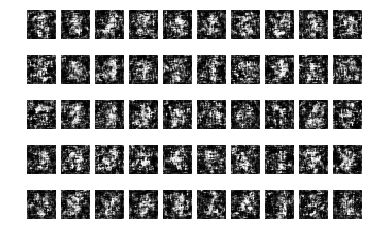

12800/12800 [==============================] - 37s 3ms/step - generator_model_loss: 0.0817 - model_2_real_0_loss: -2.0054 - model_2_fake_0_loss: -0.0134 - model_2_avg_0_loss: 1.6104 - discriminator_model_loss: -0.4084
Epoch 2/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 0.6496 - model_2_real_0_loss: -0.7679 - model_2_fake_0_loss: -0.6280 - model_2_avg_0_loss: 0.1171 - discriminator_model_loss: -1.2788

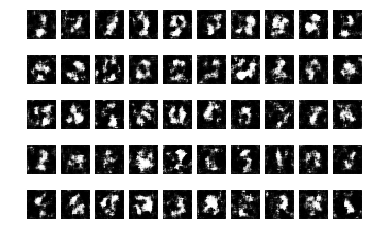

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: 0.6499 - model_2_real_0_loss: -0.7659 - model_2_fake_0_loss: -0.6285 - model_2_avg_0_loss: 0.1168 - discriminator_model_loss: -1.2776
Epoch 3/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 1.1442 - model_2_real_0_loss: -0.1139 - model_2_fake_0_loss: -1.1245 - model_2_avg_0_loss: 0.0929 - discriminator_model_loss: -1.1455

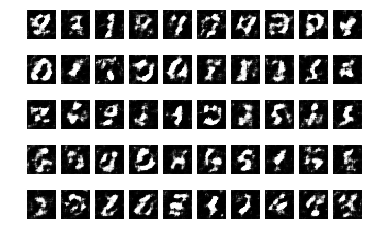

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: 1.1499 - model_2_real_0_loss: -0.1084 - model_2_fake_0_loss: -1.1296 - model_2_avg_0_loss: 0.0929 - discriminator_model_loss: -1.1451
Epoch 4/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 2.4937 - model_2_real_0_loss: 1.2365 - model_2_fake_0_loss: -2.4858 - model_2_avg_0_loss: 0.0915 - discriminator_model_loss: -1.1577

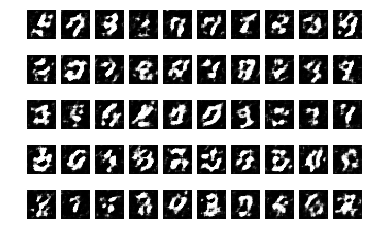

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: 2.4944 - model_2_real_0_loss: 1.2415 - model_2_fake_0_loss: -2.4908 - model_2_avg_0_loss: 0.0914 - discriminator_model_loss: -1.1579
Epoch 5/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 3.2150 - model_2_real_0_loss: 1.9909 - model_2_fake_0_loss: -3.1871 - model_2_avg_0_loss: 0.0965 - discriminator_model_loss: -1.0996

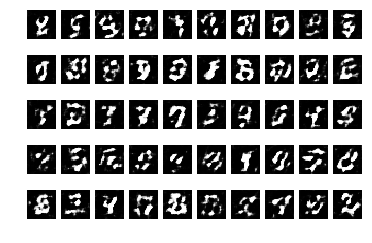

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: 3.2185 - model_2_real_0_loss: 1.9924 - model_2_fake_0_loss: -3.1896 - model_2_avg_0_loss: 0.0965 - discriminator_model_loss: -1.1007
Epoch 6/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 3.6582 - model_2_real_0_loss: 2.2449 - model_2_fake_0_loss: -3.6442 - model_2_avg_0_loss: 0.1314 - discriminator_model_loss: -1.2679

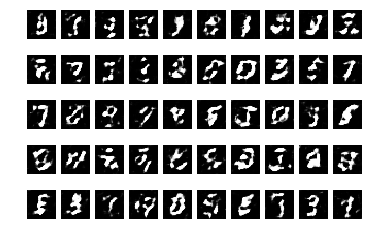

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: 3.6628 - model_2_real_0_loss: 2.2470 - model_2_fake_0_loss: -3.6481 - model_2_avg_0_loss: 0.1318 - discriminator_model_loss: -1.2693
Epoch 7/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 3.8822 - model_2_real_0_loss: 2.2299 - model_2_fake_0_loss: -3.8648 - model_2_avg_0_loss: 0.1702 - discriminator_model_loss: -1.4646

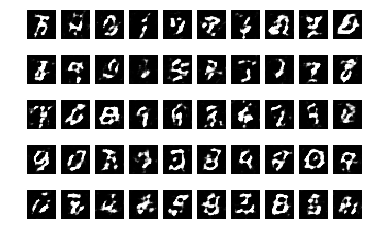

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: 3.8816 - model_2_real_0_loss: 2.2305 - model_2_fake_0_loss: -3.8664 - model_2_avg_0_loss: 0.1705 - discriminator_model_loss: -1.4653
Epoch 8/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 3.9249 - model_2_real_0_loss: 2.0615 - model_2_fake_0_loss: -3.8971 - model_2_avg_0_loss: 0.2036 - discriminator_model_loss: -1.6319

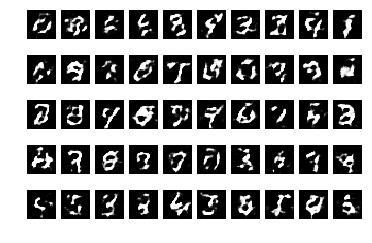

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: 3.9266 - model_2_real_0_loss: 2.0612 - model_2_fake_0_loss: -3.8972 - model_2_avg_0_loss: 0.2034 - discriminator_model_loss: -1.6326
Epoch 9/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 3.5877 - model_2_real_0_loss: 1.7370 - model_2_fake_0_loss: -3.6297 - model_2_avg_0_loss: 0.2103 - discriminator_model_loss: -1.6824

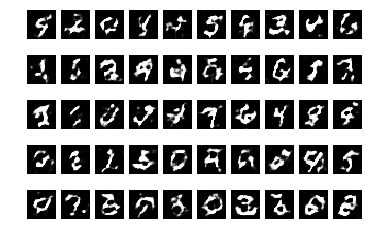

12800/12800 [==============================] - 24s 2ms/step - generator_model_loss: 3.5865 - model_2_real_0_loss: 1.7334 - model_2_fake_0_loss: -3.6260 - model_2_avg_0_loss: 0.2104 - discriminator_model_loss: -1.6821
Epoch 10/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 3.3100 - model_2_real_0_loss: 1.4816 - model_2_fake_0_loss: -3.3344 - model_2_avg_0_loss: 0.2087 - discriminator_model_loss: -1.6441

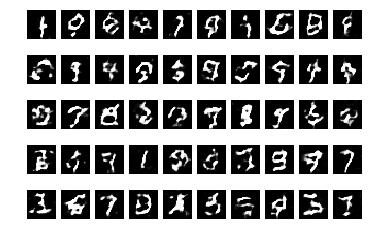

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: 3.3088 - model_2_real_0_loss: 1.4795 - model_2_fake_0_loss: -3.3325 - model_2_avg_0_loss: 0.2084 - discriminator_model_loss: -1.6446
Epoch 11/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 3.0005 - model_2_real_0_loss: 1.1054 - model_2_fake_0_loss: -2.9971 - model_2_avg_0_loss: 0.2093 - discriminator_model_loss: -1.6824

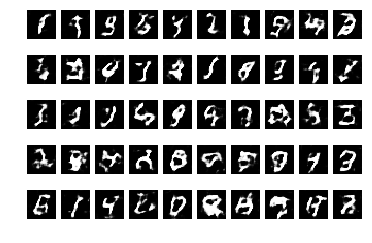

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: 2.9931 - model_2_real_0_loss: 1.1043 - model_2_fake_0_loss: -2.9933 - model_2_avg_0_loss: 0.2091 - discriminator_model_loss: -1.6798
Epoch 12/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 2.2863 - model_2_real_0_loss: 0.3028 - model_2_fake_0_loss: -2.2710 - model_2_avg_0_loss: 0.2172 - discriminator_model_loss: -1.7510

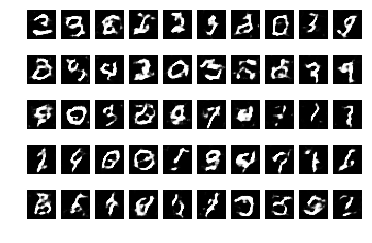

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: 2.2898 - model_2_real_0_loss: 0.2975 - model_2_fake_0_loss: -2.2662 - model_2_avg_0_loss: 0.2175 - discriminator_model_loss: -1.7511
Epoch 13/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 1.9569 - model_2_real_0_loss: -0.1426 - model_2_fake_0_loss: -1.9039 - model_2_avg_0_loss: 0.2339 - discriminator_model_loss: -1.8125

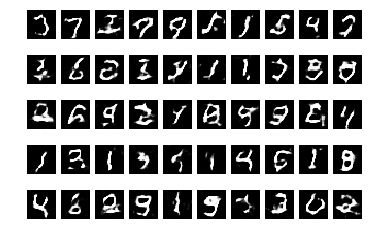

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: 1.9542 - model_2_real_0_loss: -0.1470 - model_2_fake_0_loss: -1.8998 - model_2_avg_0_loss: 0.2339 - discriminator_model_loss: -1.8129
Epoch 14/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 1.4628 - model_2_real_0_loss: -0.6204 - model_2_fake_0_loss: -1.4714 - model_2_avg_0_loss: 0.2471 - discriminator_model_loss: -1.8447

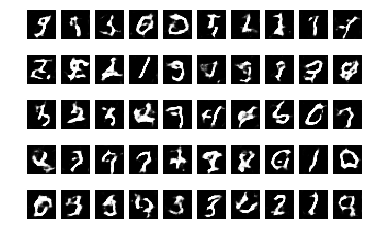

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: 1.4639 - model_2_real_0_loss: -0.6245 - model_2_fake_0_loss: -1.4666 - model_2_avg_0_loss: 0.2473 - discriminator_model_loss: -1.8437
Epoch 15/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 1.0720 - model_2_real_0_loss: -1.1339 - model_2_fake_0_loss: -1.0736 - model_2_avg_0_loss: 0.2625 - discriminator_model_loss: -1.9450

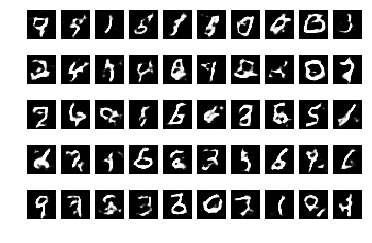

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: 1.0637 - model_2_real_0_loss: -1.1366 - model_2_fake_0_loss: -1.0738 - model_2_avg_0_loss: 0.2627 - discriminator_model_loss: -1.9477
Epoch 16/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 0.5783 - model_2_real_0_loss: -1.6447 - model_2_fake_0_loss: -0.6048 - model_2_avg_0_loss: 0.2780 - discriminator_model_loss: -1.9715

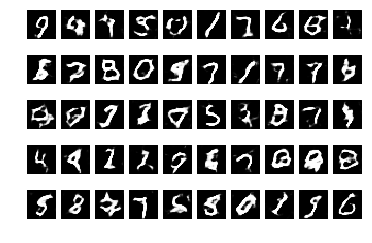

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: 0.5731 - model_2_real_0_loss: -1.6368 - model_2_fake_0_loss: -0.6097 - model_2_avg_0_loss: 0.2777 - discriminator_model_loss: -1.9688
Epoch 17/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: 0.1997 - model_2_real_0_loss: -2.0125 - model_2_fake_0_loss: -0.2162 - model_2_avg_0_loss: 0.2930 - discriminator_model_loss: -1.9357

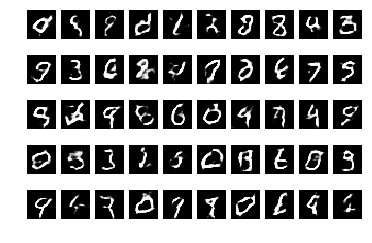

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: 0.2016 - model_2_real_0_loss: -2.0161 - model_2_fake_0_loss: -0.2157 - model_2_avg_0_loss: 0.2933 - discriminator_model_loss: -1.9385
Epoch 18/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: -0.0268 - model_2_real_0_loss: -2.3399 - model_2_fake_0_loss: 0.0837 - model_2_avg_0_loss: 0.2985 - discriminator_model_loss: -1.9577

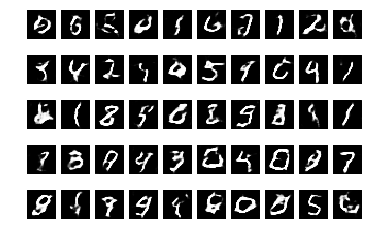

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: -0.0273 - model_2_real_0_loss: -2.3348 - model_2_fake_0_loss: 0.0810 - model_2_avg_0_loss: 0.2983 - discriminator_model_loss: -1.9554
Epoch 19/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: -0.4918 - model_2_real_0_loss: -2.8534 - model_2_fake_0_loss: 0.5007 - model_2_avg_0_loss: 0.3060 - discriminator_model_loss: -2.0466

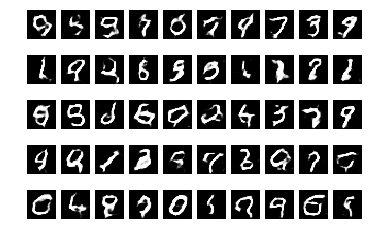

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: -0.4951 - model_2_real_0_loss: -2.8564 - model_2_fake_0_loss: 0.5019 - model_2_avg_0_loss: 0.3071 - discriminator_model_loss: -2.0474
Epoch 20/20
12672/12800 [============================>.] - ETA: 0s - generator_model_loss: -0.4865 - model_2_real_0_loss: -2.8515 - model_2_fake_0_loss: 0.4830 - model_2_avg_0_loss: 0.3286 - discriminator_model_loss: -2.0400

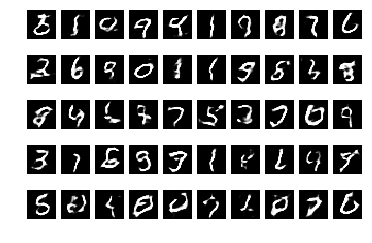

12800/12800 [==============================] - 25s 2ms/step - generator_model_loss: -0.4869 - model_2_real_0_loss: -2.8489 - model_2_fake_0_loss: 0.4855 - model_2_avg_0_loss: 0.3283 - discriminator_model_loss: -2.0351


In [0]:
def iwgan():
    model = GAN(generator=build_generator(), discriminator=build_discriminator())
    optimizer = Adam(0.00005, 0.5)
    optimizerD = Adam(0.0002, 0.5)
    try:
        shutil.rmtree('images/iwgan')
    except:
        pass
    try:
        os.makedirs('images/iwgan')
    except:
        pass
    discriminator_kwargs = {'optimizer': optimizerD}
    generator_kwargs = {'loss': wasserstein_loss, 'optimizer': optimizer}
    model.compile(training_scheme=IWGAN_TrainingScheme(batch_size=128),
                  generator_kwargs=generator_kwargs, discriminator_kwargs=discriminator_kwargs)
    return model

x,y = load_data()
model = iwgan()
model.fit(x=x, y=y, epochs=20, steps_per_epoch=100, batch_size=128, discriminator_training_multiplier=3,
          generatore_callbacks=[save_images(model=model, name='iwgan')], verbose=1)

# Training Cycle-GAN in Keras with AutoGAN 

## Downloading Dataset

In [0]:
#!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip -O ./apple2orange.zip
#!mkdir ./apple2orange/
#!unzip -q ./apple2orange.zip -d ./
#!rm ./apple2orange.zip

## Initial imports

In [0]:
import sys
import os
import shutil
from AutoGAN import GAN
from AutoGAN.schemes.CycleGAN_TrainingScheme import CycleGAN_TrainingScheme

import keras

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import UpSampling2D, LeakyReLU, Lambda, Add, Multiply, Activation, Conv2DTranspose
from keras.layers import Cropping2D, ZeroPadding2D, Flatten, Subtract, Input, add, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam 

import matplotlib.pyplot as plt
import numpy as np
import scipy
from skimage.transform import resize
import glob
from random import shuffle

## Discriminator

In [0]:
def build_discriminator(df, size):

    def d_layer(layer_input, filters, f_size=4, normalization=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = BatchNormalization()(d)
        return d

    img = Input(shape=size)

    d1 = d_layer(img, df, normalization=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*8)
    d5 = d_layer(d4, df*16)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d5)

    return Model(img, validity)


## Generator

In [0]:
def build_generator(gf, size):
    """U-Net Generator"""

    def conv2d(layer_input, filters, f_size=4):
        """Layers used during downsampling"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        d = BatchNormalization()(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization()(u)
        u = Concatenate()([u, skip_input])
        return u

    # Image input
    d0 = Input(shape=size)

    # Downsampling
    d1 = conv2d(d0, gf)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4)
    d4 = conv2d(d3, gf*8)
    d5 = conv2d(d4, gf*16)

    # Upsampling
    u0 = deconv2d(d5, d4, gf*16)
    u1 = deconv2d(u0, d3, gf*4)
    u2 = deconv2d(u1, d2, gf*2)
    u3 = deconv2d(u2, d1, gf)

    u4 = UpSampling2D(size=2)(u3)
    output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

    return Model(d0, output_img)


## Helper Functions

In [0]:
def load_data(dataset):
    filelist_A = glob.glob('./%s/trainA/*.jpg' % dataset)
    shuffle(filelist_A)
    A = np.array([plt.imread(file) for file in filelist_A])
    print(A.shape)
    A = (2. * A/255.) - 1.
    
    filelist_B = glob.glob('./%s/trainB/*.jpg' % dataset)
    shuffle(filelist_B)
    B = np.array([plt.imread(file) for file in filelist_B if plt.imread(file).shape[-1] == 3 ])
    print(B.shape)
    B = (2. * B/255.) - 1.
    return A, B

def load_data_test(dataset):
    filelist_A = glob.glob('./%s/testA/*.jpg' % dataset)
    shuffle(filelist_A)
    A = np.array([plt.imread(file) for file in filelist_A])
    print(A.shape)
    A = (2. * A/255.) - 1.
    
    filelist_B = glob.glob('./%s/testB/*.jpg' % dataset)
    shuffle(filelist_B)
    B = np.array([plt.imread(file) for file in filelist_B])
    print(B.shape)
    B = (2. * B/255.) - 1.
    return A, B


## Image Saver Callback

In [0]:
class save_images(keras.callbacks.Callback):
    def __init__(self, model, A, B, freq, dataset):
        super(save_images, self).__init__()
        try:
            import os
            os.makedirs('images/%s' % dataset)
        except:
            pass
        self.full_model = model
        self.A = A
        self.B = B
        self.epoch = 0
        self.freq = freq
        self.dataset = dataset
    def sample_images(self, epoch, A=None, B=None, end=False):
        r, c = 2, 3

        # Demo (for GIF)
        if A is None:
            if 'apple2orange' in self.dataset:
                A = np.array([plt.imread('./apple2orange/testA/n07740461_1541.jpg','jpg')])
            else:
                A = np.array([plt.imread('./horse2zebra/testA/n02381460_1300.jpg','jpg')])
            A = (2. * A/255.) - 1.
        if B is None:
            if 'apple2orange' in self.dataset:
                B = np.array([plt.imread('./apple2orange/testB/n07749192_4241.jpg','jpg')])
            else:
                B = np.array([plt.imread('./horse2zebra/testB/n02391049_9960.jpg','jpg')])
            B = (2. * B/255.) - 1.

        # Translate images to the other domain
        fake_A = self.full_model.generator_model()[0].predict(B)
        fake_B = self.full_model.generator_model()[1].predict(A)
        # Translate back to original domain
        reconstr_A = self.full_model.generator_model()[0].predict(fake_B)
        reconstr_B = self.full_model.generator_model()[1].predict(fake_A)

        gen_imgs = np.concatenate([A, fake_B, reconstr_A, B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        #gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c,figsize=(10,10))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt]+1.)/2.)
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        if end:
          try:
            shutil.rmtree('./images/%s/final_outputs'% (self.dataset))
          except:
              pass
          try:
            os.mkdir('./images/%s/final_outputs'% (self.dataset))
          except:
              pass
            
          fig.savefig("images/%s/final_outputs/%d.png" % (self.dataset, epoch))
        else:
          fig.savefig("images/%s/%d.png" % (self.dataset, epoch))
        plt.show()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch
        #print('started epoch %d' % epoch)
    def on_epoch_end(self, epoch, logs=None):
        self.sample_images(self.epoch)
    def on_train_end(self, logs=None):
        for i in range(1, self.A.shape[0]):
            try:
                self.sample_images(self.epoch+1, self.A[i-1:i], self.B[i-1:i], True)
            except:
                continue

## CycleGAN Training

In [0]:
A, B = load_data('apple2orange')
A_test, B_test = load_data_test('apple2orange')

def cyclegan(image_A, image_B):
    model = GAN(generator=[build_generator(32, image_A.shape),build_generator(32, image_B.shape)], 
                discriminator=[build_discriminator(32, image_A.shape),build_discriminator(32, image_B.shape)])
    optimizer = keras.optimizers.Adam(0.0002, 0.5)
    optimizerD = keras.optimizers.Adam(0.0001, 0.5)
    try:
        shutil.rmtree('./images/apple2orange_cyclegan')
    except:
        pass
    discriminator_kwargs = {'loss':'mse', 'optimizer': optimizerD}
    generator_kwargs = {'optimizer': optimizer,
                        'translation_weight':1, 'cycle_weight':10, 'identity_weight':1,
                        'translation_loss':'mse', 'cycle_loss':'mae', 'identity_loss':'mae'}
    model.compile(training_scheme=CycleGAN_TrainingScheme(),
                  generator_kwargs=generator_kwargs, discriminator_kwargs=discriminator_kwargs)
    return model

model = cyclegan(A[0], B[0])
#model.summary(True)
%matplotlib inline
model.fit(x=A, y=B, epochs=20, steps_per_epoch=250, batch_size=1,
          generator_callbacks=[save_images(model, A_test, B_test, 100,'apple2orange_cyclegan')], verbose=1)


(0,)
(0,)
(0,)
(0,)


IndexError: ignored

# Building CycleGAN From Scrach 

## Downloading Dataset

In [0]:
!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip -O ./apple2orange.zip
!mkdir ./apple2orange/
!unzip -q ./apple2orange.zip -d ./
!rm ./apple2orange.zip

for details.

--2019-05-21 17:17:57--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘./apple2orange.zip’

./apple2orange.zip  100%[===================>]  74.82M  20.7MB/s    in 4.4s    

2019-05-21 17:18:02 (17.0 MB/s) - ‘./apple2orange.zip’ saved [78456409/78456409]



## Initial Imports

In [0]:
import sys
import os
import shutil
from AutoGAN import GAN
from AutoGAN.schemes.CycleGAN_TrainingScheme import CycleGAN_TrainingScheme

import keras

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import UpSampling2D, LeakyReLU, Lambda, Add, Multiply, Activation, Conv2DTranspose
from keras.layers import Cropping2D, ZeroPadding2D, Flatten, Subtract, Input, add, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam 

import matplotlib.pyplot as plt
import numpy as np
import scipy
from skimage.transform import resize
import glob
from random import shuffle

## Creating Networks and Parameters

## Loading Data

In [0]:
def load_data(dataset):
    filelist_A = glob.glob('./%s/trainA/*.jpg' % dataset)
    shuffle(filelist_A)
    A = np.array([plt.imread(file) for file in filelist_A])
    print(A.shape)
    A = (2. * A/255.) - 1.
    
    filelist_B = glob.glob('./%s/trainB/*.jpg' % dataset)
    shuffle(filelist_B)
    B = np.array([plt.imread(file) for file in filelist_B if plt.imread(file).shape[-1] == 3 ])
    print(B.shape)
    B = (2. * B/255.) - 1.
    return A, B

def load_data_test(dataset):
    filelist_A = glob.glob('./%s/testA/*.jpg' % dataset)
    shuffle(filelist_A)
    A = np.array([plt.imread(file) for file in filelist_A])
    print(A.shape)
    A = (2. * A/255.) - 1.
    
    filelist_B = glob.glob('./%s/testB/*.jpg' % dataset)
    shuffle(filelist_B)
    B = np.array([plt.imread(file) for file in filelist_B])
    print(B.shape)
    B = (2. * B/255.) - 1.
    return A, B
  
A, B = load_data('apple2orange')
A_test, B_test = load_data_test('apple2orange')


(995, 256, 256, 3)
(1019, 256, 256, 3)
(266, 256, 256, 3)
(248, 256, 256, 3)


In [0]:
def build_generator(gf, size):
    """U-Net Generator"""

    def conv2d(layer_input, filters, f_size=4):
        """Layers used during downsampling"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        d = BatchNormalization()(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization()(u)
        u = Concatenate()([u, skip_input])
        return u

    # Image input
    d0 = Input(shape=size)

    # Downsampling
    d1 = conv2d(d0, gf)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4)
    d4 = conv2d(d3, gf*8)
    d5 = conv2d(d4, gf*16)

    # Upsampling
    u0 = deconv2d(d5, d4, gf*16)
    u1 = deconv2d(u0, d3, gf*4)
    u2 = deconv2d(u1, d2, gf*2)
    u3 = deconv2d(u2, d1, gf)

    u4 = UpSampling2D(size=2)(u3)
    output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

    return Model(d0, output_img)

def build_discriminator(df, size):

    def d_layer(layer_input, filters, f_size=4, normalization=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = BatchNormalization()(d)
        return d

    img = Input(shape=size)

    d1 = d_layer(img, df, normalization=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*8)
    d5 = d_layer(d4, df*16)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d5)

    return Model(img, validity) 


## Building Generator

In [0]:
generator_ab, generator_ba = build_generator(32, A[0].shape),build_generator(32, B[0].shape)
discriminator_a, discriminator_b = build_discriminator(32, A[0].shape),build_discriminator(32, B[0].shape)
optimizerG = keras.optimizers.Adam(0.0002, 0.5)
optimizer = keras.optimizers.Adam(0.0001, 0.5)

epochs = 20
steps = 100

## YOUR CODE HERE!
loss_fake =
loss_cycle =
loss_id =

w_fake = 1
w_cycle = 10
w_id = 1
## END HERE


SyntaxError: ignored

In [0]:


input_A = keras.layers.Input(A[0].shape)
input_B = keras.layers.Input(B[0].shape)

fake_B = generator_ab(input_A)
fake_A = generator_ba(input_B)

## YOUR CODE HERE!
dis_fake_A = 
dis_fake_B = 

dis_real_A = 
dis_real_B = 

reconstructed_A = 
reconstructed_B = 

Identity_A = 
Identity_B = 
## END HERE



model_gen = keras.models.Model(inputs=[input_A, input_B], outputs=[dis_fake_A, dis_fake_B, 
                                                                   reconstructed_A, reconstructed_B,
                                                                   Identity_A, Identity_B])
model_gen.compile(optimizer=optimizerG, loss=[loss_fake, loss_fake,
                                              loss_cycle, loss_cycle,
                                              loss_id, loss_id],
                  loss_weights=[w_fake, w_fake, w_cycle, w_cycle, w_id, w_id])

## Building Discriminators

In [0]:
model_dis = keras.models.Model(inputs=[input_A, input_B], outputs=[dis_real_A, dis_real_B, dis_fake_A, dis_fake_B])
model_dis.compile(optimizer=optimizer, loss=loss_fake)

## Helper Functions and Callbacks

In [0]:
class save_images_full(keras.callbacks.Callback):
    def __init__(self, model, A, B, freq, dataset):
        super(save_images_full, self).__init__()
        try:
            import os
            os.makedirs('images/%s' % dataset)
        except:
            pass
        self.full_model = model
        self.A = A
        self.B = B
        self.epoch = 0
        self.freq = freq
        self.dataset = dataset
    def sample_images(self, epoch, A=None, B=None, end=False):
        r, c = 2, 3

        # Demo (for GIF)
        if A is None:
            if 'apple2orange' in self.dataset:
                A = np.array([plt.imread('./apple2orange/testA/n07740461_1541.jpg','jpg')])
            else:
                A = np.array([plt.imread('./horse2zebra/testA/n02381460_1300.jpg','jpg')])
            A = (2. * A/255.) - 1.
        if B is None:
            if 'apple2orange' in self.dataset:
                B = np.array([plt.imread('./apple2orange/testB/n07749192_4241.jpg','jpg')])
            else:
                B = np.array([plt.imread('./horse2zebra/testB/n02391049_9960.jpg','jpg')])
            B = (2. * B/255.) - 1.

        # Translate images to the other domain
        fake_A = self.full_model[0].predict(B)
        fake_B = self.full_model[1].predict(A)
        # Translate back to original domain
        reconstr_A = self.full_model[0].predict(fake_B)
        reconstr_B = self.full_model[1].predict(fake_A)

        gen_imgs = np.concatenate([A, fake_B, reconstr_A, B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        #gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c,figsize=(10,10))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt]+1.)/2.)
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        if end:
          try:
            shutil.rmtree('./images/%s/final_outputs'% (self.dataset))
          except:
              pass
          try:
            os.mkdir('./images/%s/final_outputs'% (self.dataset))
          except:
              pass
            
          fig.savefig("images/%s/final_outputs/%d.png" % (self.dataset, epoch))
        else:
          fig.savefig("images/%s/%d.png" % (self.dataset, epoch))
        plt.show()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch
        #print('started epoch %d' % epoch)
    def on_epoch_end(self, epoch, logs=None):
        self.sample_images(self.epoch)
    def on_train_end(self, logs=None):
        for i in range(1, self.A.shape[0]):
            try:
                self.sample_images(self.epoch+1, self.A[i-1:i], self.B[i-1:i], True)
            except:
                continue

image_saver = save_images_full([generator_ab, generator_ba], A_test, B_test, 100,'apple2orange_full_cyclegan')

def get_batch():
  while 1:
    np.random.shuffle(A)
    np.random.shuffle(B)
    for a_batch, b_batch in zip(A,B):
      yield np.expand_dims(a_batch, 0), np.expand_dims(b_batch, 0)

## Training Loop

In [0]:
data_gen = get_batch()
for epoch in tqdm_notebook(range(epochs)):
  epoch_loss_dis = None
  epoch_loss_gen = None
  for step in tqdm_notebook(range(steps)):
    a, b = next(data_gen)
    ones = np.ones([1] + model_dis.outputs[0].get_shape().as_list()[1:])
    zeros = np.zeros([1] + model_dis.outputs[0].get_shape().as_list()[1:])
    
    ## YOUR CODE HERE!
    loss_dis = model_dis.train_on_batch(x=[], y=[])
    loss_gen = model_gen.train_on_batch(x=[], y=[])
    ## END HERE
    if epoch_loss_dis is None:
      epoch_loss_dis = loss_dis
    else:
      epoch_loss_dis = epoch_loss_dis + loss_dis if not isinstance(epoch_loss_dis, list)\
      else [l1+l2 for l1, l2 in zip(epoch_loss_dis, loss_dis)]     
    if epoch_loss_gen is None:
      epoch_loss_gen = loss_gen
    else:
      epoch_loss_gen = epoch_loss_gen + loss_gen if not isinstance(epoch_loss_gen, list)\
      else [l1+l2 for l1, l2 in zip(epoch_loss_gen, loss_gen)]
     
  epoch_loss_gen = epoch_loss_gen / steps if not isinstance(epoch_loss_gen, list) else [l/steps for l in epoch_loss_gen]
  epoch_loss_dis = epoch_loss_dis / steps if not isinstance(epoch_loss_dis, list) else [l/steps for l in epoch_loss_dis]
  print ("Epoch:", epoch,"\nGenerator Loss: ", epoch_loss_gen, "\nDiscriminator Loss: ", epoch_loss_dis)
  image_saver.on_epoch_end(epoch)
    
image_saver.on_train_end()